# Setup

In [1]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
import random
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

from contextlib import contextmanager

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *

/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
pd.set_option("display.width", 1000)

# Data Processing

In [5]:
df = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

In [6]:
train_df = df["20170501":"20170801"]

In [7]:
# set-wise subtraction
inf_df = df.loc[~df.index.isin(train_df.index)]

# Model

## Training

In [8]:
# train_model(train_df)

In [9]:
model = load_trained_model("A1", "D1")

/Users/aosh/Developer/helio-n/Outputs/Models/A1D1.keras


I0000 00:00:1766998511.868619 4291139 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1766998511.869163 4291139 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


## Plotting

In [10]:
def plot_sdo(
    row,
    postprocessing="P0",
    oval=None,
    show_fits=True,
):
    """
    Double plotter wrapper around plot_ch_map().
    Keeps the original signature.

    - Left: U-Net (helio-n)
    - Right: IDL
    """
    print(row)
    # Keep existing diagnostic print; assumes these globals exist in your notebook/module
    params = (
        postprocessing
        if isinstance(postprocessing, dict)
        else get_postprocessing_params(postprocessing)
    )
    print_distance(row, model, params)

    # Keep old behavior: compute oval once and reuse
    if oval is None:
        oval = generate_omask(row)

    m = sunpy.map.Map(row.fits_path)

    # Map old "smoothing_params" to the string key plot_ch_map expects.
    # This preserves call compatibility without changing plot_ch_map's signature.
    # If you have a canonical mapping util, swap this block out.

    fig = plt.figure(figsize=((TARGET_PX / DPI) * 2.1, TARGET_PX / DPI))
    ax1 = fig.add_subplot(
        1, 2, 1, projection=m
    )  # let plot_ch_map create/use WCS projection internally
    ax2 = fig.add_subplot(1, 2, 2, projection=m)

    # Left panel: U-Net
    plot_ch_map(
        row,
        source="unet",
        model=model,  # required if no pmap_path/pmap on row
        pmap=None,  # plot_ch_map will load/compute if needed
        postprocessing=postprocessing,
        oval=oval,
        show_fits=show_fits,
        ax=ax1,
        set_title=False,
    )
    ax1.set_title("helio-n (U-Net)")

    # Right panel: IDL
    plot_ch_map(
        row,
        source="idl",
        model=None,
        pmap=None,
        postprocessing=postprocessing,  # ignored for IDL, harmless to pass
        oval=oval,
        show_fits=show_fits,
        ax=ax2,
        set_title=False,
    )
    ax2.set_title("IDL")

    plt.tight_layout()
    plt.show()

In [11]:
_SUPPRESS_REDRAW = 0


@contextmanager
def suppress_redraw():
    global _SUPPRESS_REDRAW
    _SUPPRESS_REDRAW += 1
    try:
        yield
    finally:
        _SUPPRESS_REDRAW -= 1


# -------------------------
# 0) Postprocessing presets
# -------------------------
PP_DIR = Path("./Config/Postprocessing").resolve()


def list_json_presets(pp_dir: Path):
    if not pp_dir.exists():
        return ["Custom"], {"Custom": None}

    files = sorted(
        [p for p in pp_dir.iterdir() if p.is_file() and p.suffix.lower() == ".json"]
    )
    names = [p.stem for p in files]
    mapping = {p.stem: p for p in files}

    # Ensure Custom exists as an option even if file missing
    if "Custom" not in mapping:
        names = ["Custom"] + names
        mapping["Custom"] = pp_dir / "Custom.json"

    # Make Custom default and first in list
    if "Custom" in names:
        names = ["Custom"] + [n for n in names if n != "Custom"]

    return names, mapping


PRESET_NAMES, PRESET_PATHS = list_json_presets(PP_DIR)


def load_params_from_file(path: Path, fallback: dict):
    try:
        if path is None:
            return dict(fallback)
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        # Only take known keys; fallback for missing
        out = dict(fallback)
        for k in ["threshold", "closing_radius", "min_size", "hole_size"]:
            if k in data:
                out[k] = data[k]
        return out
    except Exception:
        return dict(fallback)


def write_params_to_custom(path: Path, params: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(params, f, indent=2, sort_keys=True)


# --------------------------------
# 1) Register your dataframes here
# --------------------------------
dfs = {
    "train": train_df,
    "inference": inf_df,
}

# ----------------
# 2) Widgets
# ----------------
df_selector = widgets.RadioButtons(
    options=list(dfs.keys()),
    value="inference",
    description="DataFrame:",
)

idx_slider = widgets.IntSlider(
    value=random.randint(0, len(dfs["train"]) - 1) if len(dfs["train"]) else 0,
    min=0,
    max=max(0, len(dfs["train"]) - 1),
    step=1,
    description="Index:",
    continuous_update=False,
)

show_mask_checkbox = widgets.Checkbox(
    value=False,
    description="Show Mask Only",
)

# Preset selector (radio)
preset_selector = widgets.RadioButtons(
    options=PRESET_NAMES,
    value="Custom",  # Custom is default
    description="Postproc:",
)


# ----------------------------------------
# 3.5) When preset changes, load/lock controls
# ----------------------------------------
smoothing_params = get_postprocessing_params("Custom")


def on_preset_change(change=None):
    global smoothing_params

    preset = preset_selector.value
    is_custom = preset == "Custom"
    set_custom_controls_enabled(is_custom)

    path = PRESET_PATHS.get(preset)
    params = load_params_from_file(path, fallback=smoothing_params)

    with suppress_redraw():
        threshold_slider.value = float(params["threshold"])
        closing_radius_slider.value = int(params["closing_radius"])
        min_size_slider.value = int(params["min_size"])
        hole_size_slider.value = float(params["hole_size"])

    update_plot(None)


preset_selector.observe(on_preset_change, names="value")

# Sliders (Custom-only controls)
threshold_slider = widgets.FloatSlider(
    value=smoothing_params["threshold"],
    min=0.0,
    max=1.0,
    step=0.01,
    description="Threshold",
    continuous_update=False,
)
closing_radius_slider = widgets.IntSlider(
    value=smoothing_params["closing_radius"],
    min=0,
    max=20,
    step=1,
    description="Closing R",
    continuous_update=False,
)
min_size_slider = widgets.IntSlider(
    value=smoothing_params["min_size"],
    min=0,
    max=2000,
    step=10,
    description="Min size",
    continuous_update=False,
)
hole_size_slider = widgets.FloatSlider(
    value=smoothing_params["hole_size"],
    min=0.0,
    max=5000,
    step=50,
    description="Hole area",
    continuous_update=False,
)

out = widgets.Output()

CUSTOM_CONTROLS = [
    threshold_slider,
    closing_radius_slider,
    min_size_slider,
    hole_size_slider,
]


def set_custom_controls_enabled(enabled: bool):
    for w in CUSTOM_CONTROLS:
        w.disabled = not enabled


# -------------------------------
# 3) Update slider range when DF changes
# -------------------------------
def update_slider_range(change=None):
    df = dfs[df_selector.value]
    idx_slider.max = max(0, len(df) - 1)
    if idx_slider.value > idx_slider.max:
        idx_slider.value = idx_slider.max


df_selector.observe(update_slider_range, names="value")


# -------------------------------
# 4) Main update function
# -------------------------------
def current_slider_params():
    return {
        "threshold": float(threshold_slider.value),
        "closing_radius": int(closing_radius_slider.value),
        "min_size": int(min_size_slider.value),
        "hole_size": float(hole_size_slider.value),
    }


def update_plot(change=None):
    global smoothing_params

    if _SUPPRESS_REDRAW > 0:
        return

    with out:
        clear_output(wait=True)

        df = dfs[df_selector.value]
        if len(df) == 0:
            print("Selected dataframe is empty.")
            return

        row = df.iloc[idx_slider.value]

        params = current_slider_params()
        smoothing_params = dict(params)

        postprocessing = preset_selector.value
        if postprocessing == "Custom":
            write_params_to_custom(PP_DIR / "Custom.json", smoothing_params)

        plot_sdo(
            row,
            postprocessing=postprocessing,
            show_fits=not show_mask_checkbox.value,
        )


# -------------------------------
# 5) Hook up callbacks
# -------------------------------
idx_slider.observe(update_plot, names="value")
show_mask_checkbox.observe(update_plot, names="value")
df_selector.observe(update_plot, names="value")

# Sliders should trigger updates only when Custom is active; simplest is to always call
# update_plot, but it will only persist to disk for Custom.
for w in CUSTOM_CONTROLS:
    w.observe(update_plot, names="value")

# -------------------------------
# 6) Display the UI
# -------------------------------
controls_top = widgets.HBox(
    [df_selector, idx_slider, show_mask_checkbox, preset_selector]
)
controls_bottom = widgets.HBox(
    [threshold_slider, closing_radius_slider, min_size_slider, hole_size_slider]
)

ui = widgets.VBox([controls_top, controls_bottom, out])
display(ui)

# Initial draw
update_slider_range(None)
on_preset_change(None)  # sets enabled/disabled + loads Custom if present + draws

<!-- ## Coords -->

## Coronal Hole Area

In [12]:
# 400 - no oval hole
# 200 — large central hole

In [13]:
row = df["20170801_0030":"20180701_0130"].iloc[2]
row

fits_path    /Volumes/JetDrive 330/SDO Data/FITS/2017/09/08...
mask_path    /Volumes/JetDrive 330/SDO Data/Masks/2017/08/A...
hmi_path     /Volumes/JetDrive 330/SDO Data/HMI/2017/hmi.M_...
Name: 20170801_0254, dtype: object

In [14]:
pmap_path(row, "A1", "D1")

'/Volumes/JetDrive 330/SDO Data/Masks/2017/08/AIA20170801_025404_0193_CH_MASK_A1D1PX.npy'

fits_path    /Volumes/JetDrive 330/SDO Data/FITS/2017/09/08...
mask_path    /Volumes/JetDrive 330/SDO Data/Masks/2017/08/A...
hmi_path     /Volumes/JetDrive 330/SDO Data/HMI/2017/hmi.M_...
Name: 20170801_0254, dtype: object
Fourier Distance:  0.056197232603962706
Zernike Distance:  0.18757502705365153
Center CH Area Difference (non-projective):  0.09159367656483652
I over U:  0.8761419720676258
Dice:  0.9339825931212045


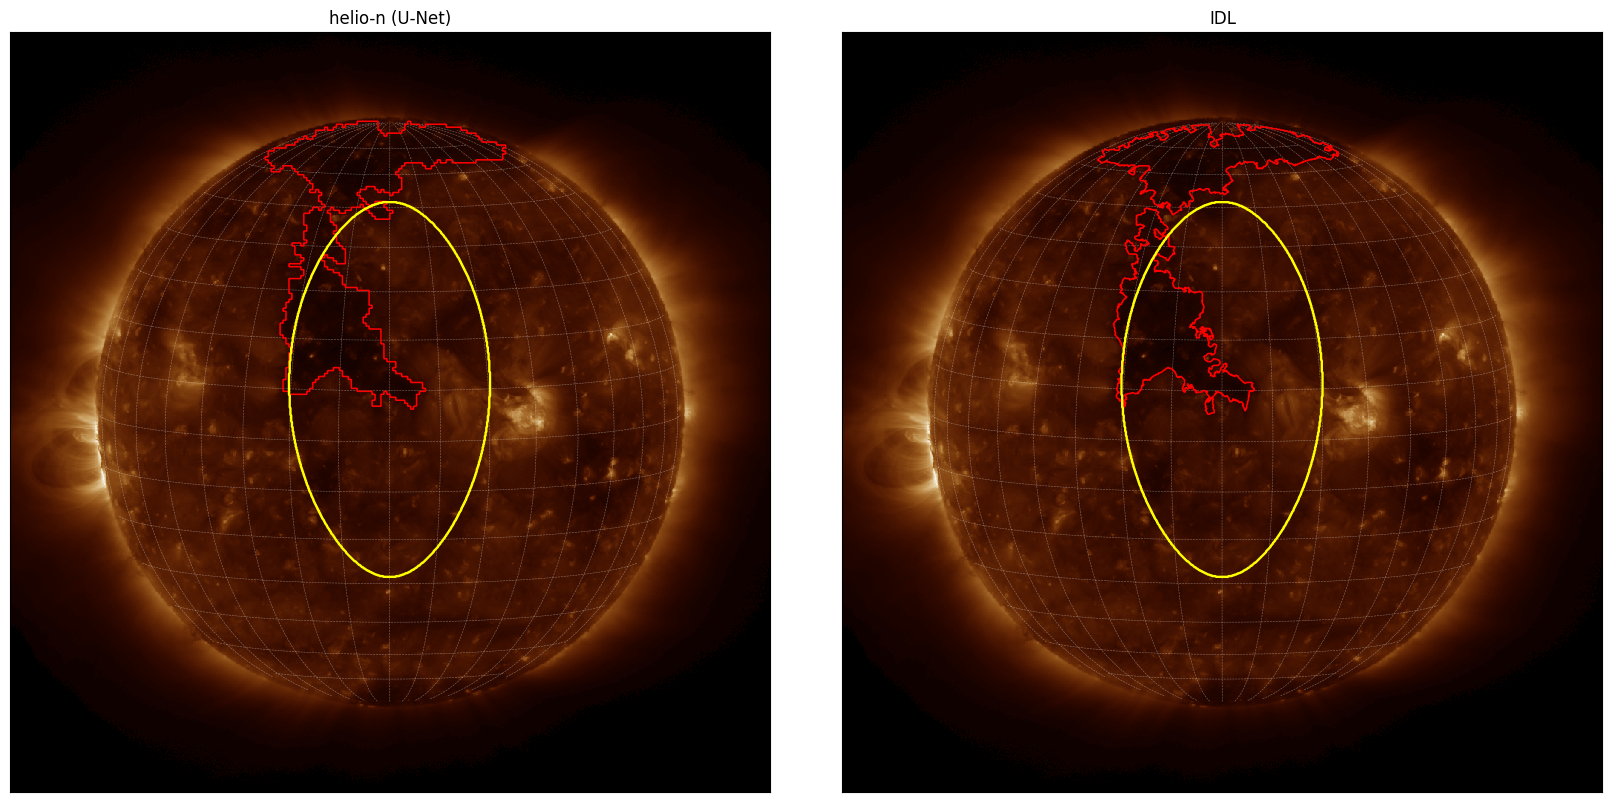

In [31]:
plot_sdo(row, "P1")

In [32]:
pmap = fits_to_pmap(model, prepare_fits(row.fits_path))

In [16]:
v_min = 300
a = 170
alpha = 0.4


def v(s):
    return v_min + a * (s * 100) ** alpha

In [22]:
v(ch_rel_area(row, reference_mode=True))

np.float64(519.7973271042019)

In [23]:
v(ch_rel_area(row, model, reference_mode=False))

np.float64(531.321569847388)

In [ ]:
ch_rel_area(row, reference_mode=True)

In [ ]:
df

In [ ]:
ddf.index = df["20181201_0000":"20181231_2359"].copy().iloc[::3].index

In [ ]:
ddf["ch_unet"] = ddf.apply(lambda x: ch_rel_area(x, reference_mode=False), axis=1)

In [ ]:
ddf["ch_idl"] = ddf.apply(lambda x: ch_rel_area(x, reference_mode=True), axis=1)

In [ ]:
ddf["v_idl"] = ddf["ch_idl"].apply(lambda s: v(s))
ddf["v_unet"] = ddf["ch_unet"].apply(lambda s: v(s))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator


# If you want the index as real datetimes instead of strings, uncomment:
# ddf.index = pd.to_datetime(ddf.index, format="%Y_%m%d")

fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 6),
)

# --- Top panel: ch_idl and unet_idl ---
ax1.plot(ddf.index, ddf["ch_idl"], label="CH Area (Ground Truth)")
ax1.plot(ddf.index, ddf["ch_unet"], label="CH Area (U-Net)")
ax1.set_ylabel("IDL value")
ax1.legend()

# --- Bottom panel: v_idl and v_unet ---
ax2.plot(ddf.index, ddf["v_idl"], label="Velocity (Ground Truth)")
ax2.plot(ddf.index, ddf["v_unet"], label="Velocity (U-Net)")
ax2.set_ylabel("Velocity")
ax2.set_xlabel("Time")
ax2.legend()

ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))  # ~6 major ticks total
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Polarity

In [ ]:
def plot_with_polarity(row, smoothing_params, B_thresh=0.15):
    """
    row: DataFrame row with row.fits_path and row.mask_path and row.hmi_path (JPG)
    smoothing_params: mask-via-model parameters
    """

    aia = prepare_fits(row.fits_path)  # (1024×1024, normalized)
    hmi = prepare_hmi_jpg()  # upscale JPG → match AIA grid

    nn_mask_raw = pmap_to_mask(row, smoothing_params)
    nn_mask = nn_mask_raw > 0.5

    idl_mask_raw = prepare_mask(row.mask_path)
    idl_mask = idl_mask_raw > 0.5

    # polarity masks using pseudo-HMI field
    nn_pos = nn_mask & (hmi >= B_thresh)
    nn_neg = nn_mask & (hmi <= -B_thresh)

    idl_pos = idl_mask & (hmi >= B_thresh)
    idl_neg = idl_mask & (hmi <= -B_thresh)

    # build RGBA overlays
    def make_overlay(pos, neg, alpha=0.5):
        h, w = pos.shape
        rgba_pos = np.zeros((h, w, 4), dtype=np.float32)
        rgba_neg = np.zeros((h, w, 4), dtype=np.float32)

        rgba_pos[..., 0] = 1.0  # red
        rgba_pos[..., 3] = alpha * pos.astype(float)

        rgba_neg[..., 2] = 1.0  # blue
        rgba_neg[..., 3] = alpha * neg.astype(float)

        return rgba_pos, rgba_neg

    nn_overlay_pos, nn_overlay_neg = make_overlay(nn_pos, nn_neg)
    idl_overlay_pos, idl_overlay_neg = make_overlay(idl_pos, idl_neg)

    # plots
    print_distance(row, smoothing_params)
    plt.figure(figsize=(10, 5))

    # ------------------ U-Net ------------------
    plt.subplot(1, 2, 1)
    plt.imshow(aia, cmap=cmap)
    plt.contour(nn_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(nn_overlay_pos)
    plt.imshow(nn_overlay_neg)
    plt.title("helio-n: red=+, blue=-")
    plt.axis("off")

    # ------------------ IDL ------------------
    plt.subplot(1, 2, 2)
    plt.imshow(aia, cmap=cmap)
    plt.contour(idl_mask.astype(float), levels=[0.5], colors="red")
    plt.imshow(idl_overlay_pos)
    plt.imshow(idl_overlay_neg)
    plt.title("IDL: red=+, blue=-")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# plot_with_polarity(inf_df.iloc[13385], smoothing_params)

## Stats

In [ ]:
def compute_stats_for_df(df, key, model, smoothing_params, oval):
    """
    Compute stats(row, pmap, mask) for every row and store only the result.

    df: DataFrame (with at least df.fits_path)
    model: your trained U-Net
    smoothing_params: dict for pmap_to_mask
    stats_fn: function(row, pmap, mask) -> small dict or scalar

    Returns: the same df, with df["stats"] filled.
    """
    df = df.copy()  # safe
    stats_results = []  # will become df["stats"]
    stats_results_oval = []  # will become df["stats"]

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row.pmap_path is not None:
            pmap = prepare_pmap(row.pmap_path)
        else:
            # 1. Load FITS → normalized 1024×1024
            img = prepare_fits(row.fits_path)

            # 2. Predict → probability map (img_size×img_size)
            pmap = fits_to_pmap(model, img)

            del img

        # 3. Morphology → binary mask (img_size×img_size)
        mask = pmap_to_mask(pmap, smoothing_params)
        mask = np.array(mask).astype(float)  # ensure numeric

        # 4. Compute only *tiny* stats
        s = stats(row, smoothing_params, m2=mask, model=model, oval=None)
        stats_results.append(s)
        s = stats(row, smoothing_params, m2=mask, model=model, oval=oval)
        stats_results_oval.append(s)

        # 5. Free memory
        del pmap, mask
        gc.collect()

    df["stats"] = stats_results
    df["stats_oval"] = stats_results_oval
    return df

In [ ]:
df2014 = df["20140101":"20150101"]

In [ ]:
df2014 = compute_stats_for_df(df2014, "stats", model, smoothing_params, generate_omask())
!curl -d "2014 stats calculated" ntfy.sh/helio-n

In [ ]:
df2014.to_parquet("./Outputs/Stats2014.parquet")

In [ ]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

# ---- 1. Prepare df with datetime ----
df = df2014.copy()
df.index.name = "key"

dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
df = df[~dt_index.isna()].copy()
df["time"] = dt_index[~dt_index.isna()]
df = df.sort_values("time")

# ---- 2. Expand stats dict column ----
stats_df = df["stats_oval"].apply(pd.Series)
stats_df.index = df["time"]

stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
stats_df = stats_df.resample("1d").median()
stats_df

In [ ]:
# ---- 3. Determine which rows are in training set ----
train_idx = set(train_df.index.astype(str))
is_train = df.index.astype(str).isin(train_idx)

# ---- 4. Make the plot with 3 axes ----
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True, gridspec_kw={"hspace": 0.15}
)

times = stats_df.index

# ====================================================
# AXIS 1 — Dice / IoU (remove zeros)
# ====================================================
if "dice" in stats_df:
    dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
    ax1.plot(dice_clean.index, dice_clean, label="dice", alpha=0.5)

if "iou" in stats_df:
    iou_clean = stats_df["iou"].replace([0], pd.NA).dropna()
    ax1.plot(iou_clean.index, iou_clean, label="iou", alpha=0.5)

ax1.axhline(1, color="black")
ax1.set_ylabel("Dice / IoU")
ax1.legend(loc="upper right")

# ====================================================
# AXIS 2 — Fourier / Zernike distances (remove ones)
# ====================================================
if "fourier_distance" in stats_df:
    fd_clean = stats_df["fourier_distance"].replace([1], pd.NA).dropna()
    ax2.plot(fd_clean.index, fd_clean, label="fourier_distance", alpha=0.5)

if "zernike_distance" in stats_df:
    zd_clean = stats_df["zernike_distance"].replace([1], pd.NA).dropna()
    ax2.plot(zd_clean.index, zd_clean, label="zernike_distance", alpha=0.5)

ax2.axhline(0, color="black")
ax2.set_ylabel("Shape Distances")
ax2.legend(loc="upper right")

# ====================================================
# AXIS 3 — rel_area (remove NaN and zeros)
# ====================================================
if "rel_area" in stats_df:
    rel = np.abs(stats_df["rel_area"].replace([0], pd.NA).dropna())
    ax3.plot(rel.index, rel, label="rel_area")
    ax3.axhline(1, color="black")

ax3.set_ylabel("Relative Area")
ax3.set_xlabel("Time")
ax3.legend(loc="upper right")

# ====================================================
# 5. Shade training intervals
# ====================================================
axes = [ax1, ax2, ax3]
mask = is_train
t_array = df["time"].to_numpy()
n = len(mask)

for ax in axes:
    i = 0
    while i < n:
        if mask[i]:
            start = t_array[i]
            j = i
            while j + 1 < n and mask[j + 1]:
                j += 1
            end = t_array[j]
            ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
            i = j + 1
        else:
            i += 1

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
# stats_df:
# DatetimeIndex, daily
# columns: ["fourier_distance", "zernike_distance", "rel_area", "iou", "dice"]
# some NaNs


# 1) Add a "catastrophic failure" flag per day
#    Definition: dice < 0.3 OR iou < 0.2 (you can tweak these)
def add_catastrophic_flag(stats_df, dice_thr=0.3, iou_thr=0.2):
    df = stats_df.copy()
    # work only where metrics are defined
    mask_valid = df[["dice", "iou"]].notna().all(axis=1)
    df["catastrophic"] = False
    df.loc[mask_valid, "catastrophic"] = (df.loc[mask_valid, "dice"] < dice_thr) | (
        df.loc[mask_valid, "iou"] < iou_thr
    )
    return df


stats_df_ext = add_catastrophic_flag(stats_df)


# 2) Build monthly summary:
#    - median, 25th, 75th percentiles of all metrics
#    - catastrophic fraction per month
def build_monthly_summary(stats_df_ext):
    """
    stats_df_ext: daily stats with columns
      fourier_distance, zernike_distance, rel_area, iou, dice, catastrophic
    index: DatetimeIndex (daily)
    """

    # We'll ignore days where a metric is NaN for its aggregation
    # (resample + agg will do that by default)
    monthly = stats_df_ext.resample("7d").agg(
        {
            "dice": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "iou": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "rel_area": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "fourier_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "zernike_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "catastrophic": "mean",  # fraction of catastrophic days in month
        }
    )

    # Clean up column names
    monthly.columns = [
        "dice_median",
        "dice_q25",
        "dice_q75",
        "iou_median",
        "iou_q25",
        "iou_q75",
        "rel_area_median",
        "rel_area_q25",
        "rel_area_q75",
        "fourier_median",
        "fourier_q25",
        "fourier_q75",
        "zernike_median",
        "zernike_q25",
        "zernike_q75",
        "catastrophic_fraction",
    ]

    return monthly


monthly_stats = build_monthly_summary(stats_df_ext)


# 3) Plot monthly medians + IQR + catastrophe rate
def plot_monthly_summary(monthly_stats):
    """
    monthly_stats: output of build_monthly_summary()
    index: month-end DateTimeIndex
    """

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    ax1, ax2, ax3 = axes

    # --- Panel 1: Dice & IoU (median + IQR) ---
    ax1.plot(
        monthly_stats.index,
        monthly_stats["dice_median"],
        label="Dice (median)",
        marker="o",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["dice_q25"],
        monthly_stats["dice_q75"],
        alpha=0.2,
        label="Dice IQR",
    )

    ax1.plot(
        monthly_stats.index,
        monthly_stats["iou_median"],
        label="IoU (median)",
        marker="s",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["iou_q25"],
        monthly_stats["iou_q75"],
        alpha=0.2,
        label="IoU IQR",
    )

    ax1.set_ylabel("Dice / IoU")
    ax1.set_ylim(0.0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower left")

    # --- Panel 2: rel_area + shape distances (medians only) ---
    # If rel_area is signed, median near 0 is good; you can also plot abs(rel_area)
    ax2.plot(
        monthly_stats.index,
        monthly_stats["rel_area_median"],
        label="rel_area (median)",
        marker="o",
        linewidth=1,
    )

    ax2.plot(
        monthly_stats.index,
        monthly_stats["fourier_median"],
        label="Fourier distance (median)",
        marker="s",
        linewidth=1,
    )
    ax2.plot(
        monthly_stats.index,
        monthly_stats["zernike_median"],
        label="Zernike distance (median)",
        marker="^",
        linewidth=1,
    )

    ax2.set_ylabel("Area / shape metrics")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")

    # --- Panel 3: fraction of catastrophic frames per month ---
    ax3.plot(
        monthly_stats.index,
        monthly_stats["catastrophic_fraction"],
        label="Catastrophic fraction",
        marker="o",
        linewidth=1,
    )
    ax3.fill_between(
        monthly_stats.index,
        0,
        monthly_stats["catastrophic_fraction"],
        alpha=0.2,
    )

    ax3.set_ylabel("Frac(Dice<0.3 or IoU<0.2)")
    ax3.set_xlabel("Time")
    ax3.set_ylim(0.0, 1.0)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper left")

    axes = [ax1, ax2, ax3]
    mask = is_train
    t_array = df["time"].to_numpy()
    n = len(mask)

    for ax in axes:
        i = 0
        while i < n:
            if mask[i]:
                start = t_array[i]
                j = i
                while j + 1 < n and mask[j + 1]:
                    j += 1
                end = t_array[j]
                ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
                i = j + 1
            else:
                i += 1

    plt.tight_layout()
    plt.show()


plot_monthly_summary(monthly_stats)

In [ ]:
row